<a href="https://colab.research.google.com/github/bioknight454/ATSVISION/blob/main/UTSvision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
import time
import joblib


In [4]:
# Load dataset
def load_emnist(path):
    data = pd.read_csv(path, header=None)
    # Pisahkan label dan piksel
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:].values
    return X, y

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path ke dataset EMNIST
emnist_path = "/content/drive/MyDrive/emnist-letters-train.csv"

print("Memuat dataset EMNIST...")
X, y = load_emnist(emnist_path)
print(f"Dataset dimuat: {X.shape[0]} sampel, {X.shape[1]} fitur")

Memuat dataset EMNIST...
Dataset dimuat: 88800 sampel, 784 fitur


In [7]:
#Sample LOOCV
max_samples = 2600
if len(X) > max_samples:
    X = X[:max_samples]
    y = y[:max_samples]
    print(f"Menggunakan subset {max_samples} sampel untuk LOOCV")

Menggunakan subset 2600 sampel untuk LOOCV


In [8]:
# Reshape dan normalisasi gambar
def preprocess_images(X):
    images = []
    for img in X:
        # Reshape ke bentuk 28x28 dan transpose
        img = img.reshape(28, 28).T
        img = img.astype('float32') / 255.0
        images.append(img)
    return np.array(images)
print("Memproses gambar...")
X_images = preprocess_images(X)

Memproses gambar...


In [9]:
# Ekstraksi fitur HOG
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
    features = []
    for image in images:
        # Ekstrak fitur HOG
        fd, hog_image = hog(image, orientations=orientations,
                            pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block,
                            visualize=True, feature_vector=True)
        features.append(fd)
    return np.array(features)

In [10]:
# Parameter HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

print("Mengekstrak fitur HOG...")
X_hog = extract_hog_features(X_images, orientations, pixels_per_cell, cells_per_block)

Mengekstrak fitur HOG...


In [11]:
# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hog)

In [12]:
# Inisialisasi SVM
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

In [13]:
# LOOCV
loo = LeaveOneOut()
y_true = []
y_pred = []
accuracies = []

print("Memulai evaluasi LOOCV...")
start_time = time.time()

for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm.fit(X_train, y_train)
    prediction = svm.predict(X_test)

    y_true.append(y_test[0])
    y_pred.append(prediction[0])
    accuracies.append(accuracy_score(y_test, prediction))

    # Progress update
    if len(y_true) % 100 == 0:
        print(f"Proses: {len(y_true)}/{len(X_scaled)} sampel")

total_time = time.time() - start_time
print(f"Waktu total LOOCV: {total_time:.2f} detik")

Memulai evaluasi LOOCV...
Proses: 100/2600 sampel
Proses: 200/2600 sampel
Proses: 300/2600 sampel
Proses: 400/2600 sampel
Proses: 500/2600 sampel
Proses: 600/2600 sampel
Proses: 700/2600 sampel
Proses: 800/2600 sampel
Proses: 900/2600 sampel
Proses: 1000/2600 sampel
Proses: 1100/2600 sampel
Proses: 1200/2600 sampel
Proses: 1300/2600 sampel
Proses: 1400/2600 sampel
Proses: 1500/2600 sampel
Proses: 1600/2600 sampel
Proses: 1700/2600 sampel
Proses: 1800/2600 sampel
Proses: 1900/2600 sampel
Proses: 2000/2600 sampel
Proses: 2100/2600 sampel
Proses: 2200/2600 sampel
Proses: 2300/2600 sampel
Proses: 2400/2600 sampel
Proses: 2500/2600 sampel
Proses: 2600/2600 sampel
Waktu total LOOCV: 1911.06 detik


In [14]:
# Evaluasi performa
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nHasil Evaluasi:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Hasil Evaluasi:
Accuracy: 0.8000
Precision: 0.8012
F1-score: 0.8003

Confusion Matrix:
[[62  0  1  3  5  0  2  5  0  0  0  0  2  4  4  1  7  0  0  0  0  0  0  0
   0  4]
 [ 1 74  0  0  0  0  3  6  0  0  1  1  0  0  1  1  2  3  0  0  0  0  0  0
   0  0]
 [ 2  0 87  0 10  0  2  0  0  0  1  3  0  0  2  0  0  3  1  0  0  0  0  0
   0  0]
 [ 2  3  0 86  0  0  0  0  2  2  0  1  0  0  1  2  0  0  0  0  0  0  0  0
   0  0]
 [ 2  0 10  0 78  6  1  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  0
   0  0]
 [ 1  0  0  0  1 75  0  0  1  1  0  1  0  0  0  1  2  2  3  4  0  0  0  0
   0  0]
 [ 3  1  2  0  2  0 51  1  0  0  1  0  1  0  1  1 19  0  2  1  0  0  0  0
   0  0]
 [ 0  4  0  1  0  0  1 92  1  0  0  2  0  1  0  0  0  0  0  1  1  0  1  0
   0  0]
 [ 0  0  0  2  0  0  1  0 45  3  0 39  0  2  0  0  0  0  0  2  0  0  0  0
   0  0]
 [ 0  0  0  2  0  0  0  0  5 85  0  1  0  0  0  0  0  0  2  2  0  0  0  0
   0  0]
 [ 0  4  0  0  0  1  0  3  0  0 81  0  1  1  0  0  0  1  0  1  1  0  0  0
   0  0]

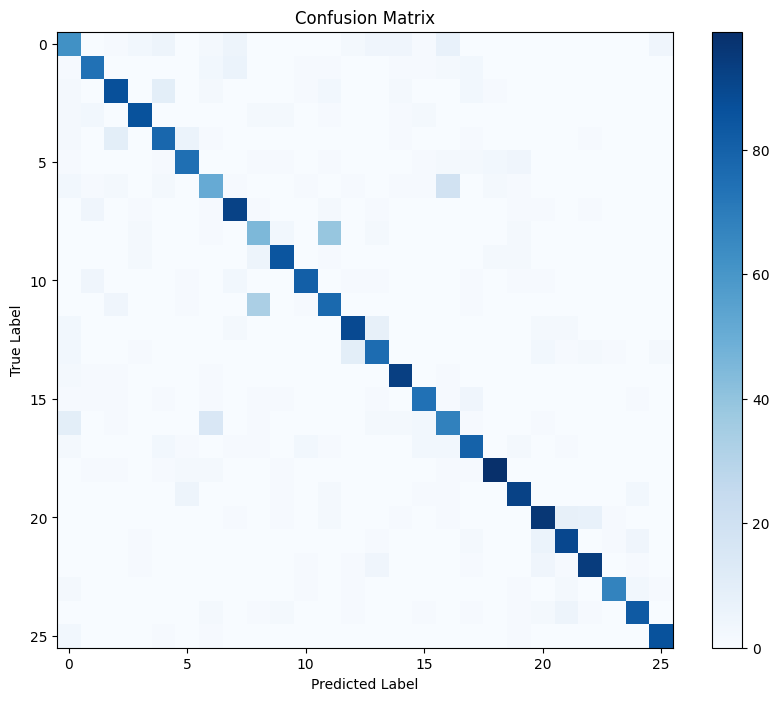

In [15]:
# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()